notebook to plot data from `NT_Src` and hopefully repeat the calculations in python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
source_dir = '../../CDMS/supersim/CDMSsources/spectra/neutron/'

source_files = {'U': 'norite_2013_U_1ppb.dat', 'Th': 'norite_2013_Th_1ppb.dat'}

data_file = 'data/V1/data_Norite_100_Sg.dat'

In [3]:
dat = pd.read_csv(data_file,sep = ' ', index_col = 0, names = ['Eg', 'Sg'])

Eg = dat.Eg.values
Sg = dat.Sg.values
gs = dat.index

def plottable(E, S):
    return (E[1:] + E[:-1])/2, S[1:]

In [4]:
src_dfs = {Z: pd.read_csv(source_dir + source_files[Z], sep = '\t', index_col = False, names = ['E', 'spec']) for Z in source_files}

EU = src_dfs['U'].E.values
specU = src_dfs['U'].spec.values
ETh = src_dfs['Th'].E.values
specTh = src_dfs['Th'].spec.values

if all(EU==ETh):
    spec = (1.095e3)*specU + (5.715e3)*specTh

In [5]:
def interp(x, x1, y1, x2, y2):
    return y1 + (x-x1)*(y2-y1)/(x2-x1)

def trap(x, y):
    return ((y[1:] + y[:-1])*(x[1:] - x[:-1])).sum()/2

In [6]:
Sg2 = np.zeros(Sg.shape)
minE = EU[0]
maxE = EU[-1]

for g in range(1,len(Sg)):
    gmin = Eg[g]
    gmax = Eg[g-1]
    if gmax < minE or maxE < gmin:
        continue

    idx = np.where((gmin < EU)*(EU < gmax))[0]

    E_eval = list(EU[idx])
    S_eval = list(spec[idx])

    id_less = np.where(EU < gmin)[0]
    if len(id_less) > 0:
        E_eval = [gmin] + E_eval
        i = id_less[-1]
        S1 = interp(gmin, EU[i], spec[i], EU[i+1], spec[i+1])
        S_eval = [S1] + S_eval
        
    id_greater = np.where(gmax < EU)[0]
    if len(id_greater) > 0:
        E_eval = E_eval + [gmax]
        i = id_greater[0]
        S2 = interp(gmax, EU[i-1], spec[i-1], EU[i], spec[i])
        S_eval = S_eval + [S2]


    E_eval = np.array(E_eval)
    S_eval = np.array(S_eval)/EU[0]

    Sg2[g] = trap(E_eval, S_eval)


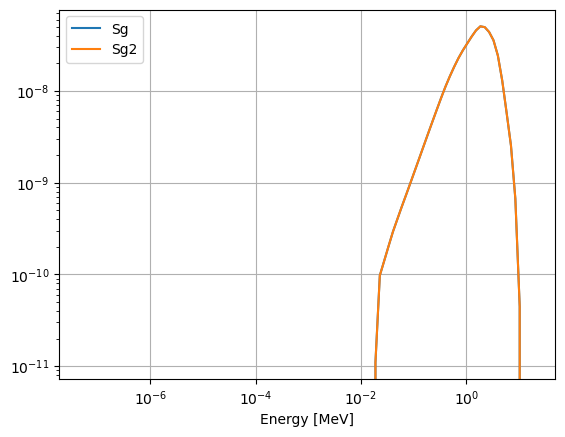

In [7]:
plt.figure()
plt.loglog()
plt.grid()
plt.xlabel('Energy [MeV]')

plt.plot(*plottable(Eg, Sg), label = 'Sg')
plt.plot(*plottable(Eg, Sg2), label = 'Sg2')

plt.legend()

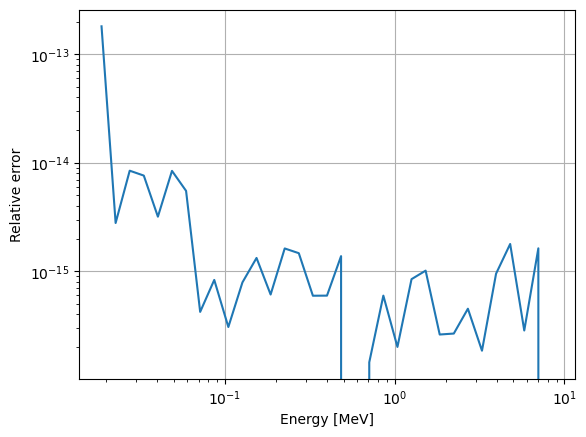

In [8]:
plt.figure()
plt.loglog()
plt.grid()
plt.xlabel('Energy [MeV]')
plt.ylabel('Relative error')
nz = Sg != 0
plt.plot(*plottable(Eg[nz], abs(Sg[nz]-Sg2[nz])/Sg[nz]))

In [9]:
all((Sg == 0) == (Sg2 == 0))

True

In [10]:
oops = np.where((Sg == 0) != (Sg2 == 0))
oops

(array([], dtype=int64),)

In [11]:
Sg[4], Sg2[4]

(4.467222407495235e-11, 4.467222407495235e-11)

In [12]:
Eg[4], Eg[3]

(9.310838545560264, 11.271951093403215)

In [13]:
EU[-3:]

array([ 9.96,  9.98, 10.  ])

In [14]:
Sg.sum()

4.6985943399449996e-07

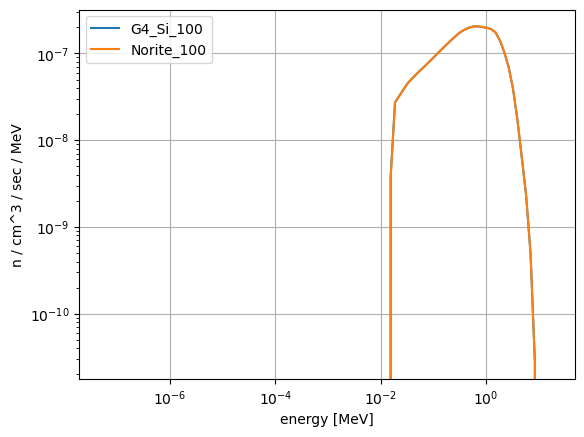

In [15]:
# comparing source evals for Si/norite
plt.figure()
plt.loglog()
plt.grid()
plt.xlabel('energy [MeV]')
plt.ylabel('n / cm^3 / sec / MeV')

for mat, G in [('G4_Si', 100), ('Norite', 100)]:

    Src = pd.read_csv(f'../sources/data/V1/data_{mat}_{G}_Sg.dat', sep = ' ', index_col = 0, names = ['Eg','Sg'])

    Eg = Src.Eg.values
    Es = (Eg[1:] + Eg[:-1])/2
    dE = abs(Eg[1:] - Eg[:-1])
    Sg = Src.Sg.values[:-1]/dE

    plt.plot(Es, Sg, label = f'{mat}_{G}')

    plt.legend()